# Regressionanalyse Wiedergabedauer

#### Hier werden die Pickle-Objekte mit den Train-, Val- und Testdaten geladen

In [ ]:

# Zelle 1: Setup und Imports
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Plotstil festlegen (verwenden einen basic matplotlib style)
plt.style.use('default')
# Seaborn Plotting Style setzen
sns.set_theme(style="whitegrid")

%matplotlib inline

plt.rcParams['font.family'] = 'DejaVu Sans'  # Alternativ: 'Liberation Sans', 'Arial Unicode MS'

# Display-Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Zelle 2: Laden der vorverarbeiteten Daten
# Laden der Pickle-Datei
with open('../data/processed/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Extrahieren der einzelnen Komponenten
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
#scaler = data['scaler']
feature_columns = data['feature_columns']
target_columns = data['target_columns']

# Überprüfung der geladenen Daten
print("Daten erfolgreich geladen!")
print(f"\nTrainings-Set Dimensionen:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"\nFeature-Spalten:")
print(feature_columns)
print(f"\nZiel-Spalten:")
print(target_columns)

# Zelle 3: Kurze Dateninspektion
# Überblick über die Feature-Verteilungen
print("\nStatistische Kennzahlen der Features im Trainingsset:")
print(X_train.describe())

# Überblick über die Zielvariblen
print("\nStatistische Kennzahlen der Zielvariablen im Trainingsset:")
print(y_train.describe())

# Visualisierung der Verteilung der Zielvariablen
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Verteilung der Zielvariablen')

for i, col in enumerate(target_columns):
    sns.histplot(data=y_train, x=col, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

#### Allgemeine Analyse
nur erst einmal die Funktionsdefinition

In [3]:
def analyze_features_for_target(X_train, y_train, target_name, feature_columns):
    """
    Führt eine umfassende Feature-Analyse für eine Zielvariable durch
    """
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.linear_model import Lasso
    from sklearn.impute import SimpleImputer
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Nur numerische Spalten auswählen
    numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_numeric = X_train[numeric_features]
    
    # Imputation der fehlenden Werte
    imputer = SimpleImputer(strategy='mean')
    X_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(X_numeric),
        columns=X_numeric.columns
    )
    
    target = y_train[target_name]
    results = {}
    
    # 1. F-Regression
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_numeric_imputed, target)
    
    f_scores = pd.DataFrame({
        'Feature': numeric_features,
        'F_Score': selector.scores_,
        'P_Value': selector.pvalues_
    }).sort_values('F_Score', ascending=False)
    
    results['f_scores'] = f_scores
    
    # 2. Lasso
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_numeric_imputed, target)
    
    lasso_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Coefficient': np.abs(lasso.coef_)
    }).sort_values('Coefficient', ascending=False)
    
    results['lasso'] = lasso_importance
    
    # 3. Korrelationsanalyse
    correlation_matrix = X_numeric_imputed.corr()
    high_correlations = np.where(np.abs(correlation_matrix) > 0.7)
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y], 
                        correlation_matrix.iloc[x, y])
                       for x, y in zip(*high_correlations) 
                       if x != y and x < y]
    
    results['high_correlations'] = high_corr_pairs
    
    # Visualisierungen
    plt.figure(figsize=(12, 6))
    sns.barplot(data=f_scores.head(10), x='F_Score', y='Feature')
    plt.title(f'Top 10 Features nach F-Score für {target_name}')
    plt.tight_layout()
    plt.show()
    
    # Zusätzliche Information über fehlende Werte
    missing_values = X_numeric.isnull().sum()
    results['missing_values'] = missing_values[missing_values > 0]
    
    return results
# Verwendung:
# Führen Sie diese Analyse für jede Zielvariable durch:
# results = analyze_features_for_target(X_train, y_train, 'durchschnittliche_wiedergabedauer', feature_columns)
# 
# print("Top 10 Features nach F-Score:")
# print(results['f_scores'].head(10))
# 
# print("\nTop 10 Features nach Lasso-Koeffizienten:")
# print(results['lasso'].head(10))
# 
# print("\nStark korrelierte Features:")
# for pair in results['high_correlations']:
#     print(f"{pair[0]} -- {pair[1]}: {pair[2]:.3f}")

#### Jetzt folgen F-Test-Analyse und Korrelationen zur Zielvariable Wiedergabedauer
für die Analyse der verschiedenen Zielvariablen, die entsprechende Zeile auskommentieren

In [ ]:
# Analyse für durchschnittliche Wiedergabedauer
#results = analyze_features_for_target(X_train, y_train, 'durchschnittliche_wiedergabedauer', feature_columns)
#results = analyze_features_for_target(X_train, y_train, 'aufrufe', feature_columns)
results = analyze_features_for_target(X_train, y_train, 'Klickrate der Impressionen (%)', feature_columns)

# Ausgabe der Ergebnisse
print("Top 10 Features nach F-Score:")
print(results['f_scores'].head(10))

print("\nTop 10 Features nach Lasso-Koeffizienten:")
print(results['lasso'].head(10))

print("\nStark korrelierte Features:")
for pair in results['high_correlations']:
    print(f"{pair[0]} -- {pair[1]}: {pair[2]:.3f}")

print("\nFehlende Werte in den Features:")
print(results['missing_values'])

#### Hier eine Analyse, inwieweit die Bewertung des Titels eine Rolle spielt. 

Statistiken zu Gestaltung_Thumbnail:
count    856.000000
mean       1.995327
std        0.733478
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Gestaltung_Thumbnail, dtype: float64

Korrelation zwischen Gestaltung_Thumbnail und aufrufe: 0.0320532565460942


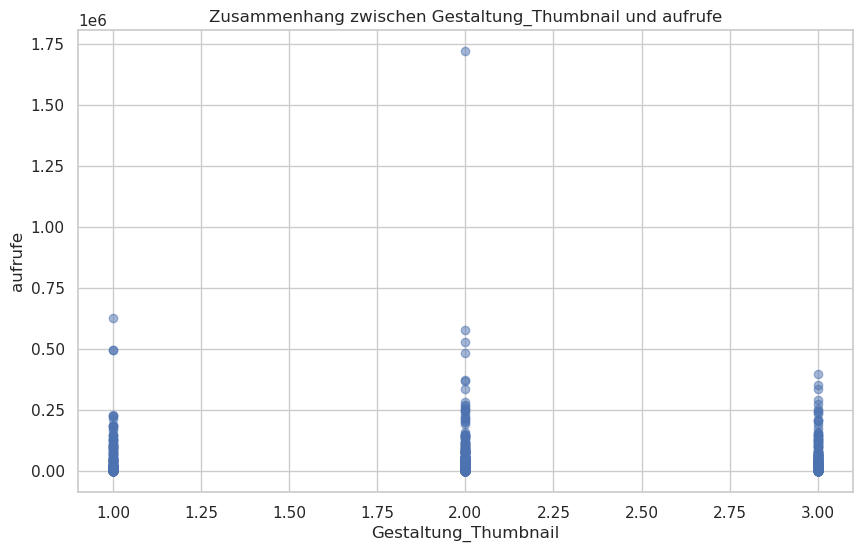


Anzahl fehlender Werte in Gestaltung_Thumbnail: 0


In [15]:
# Variablen definieren
predictor = 'Gestaltung_Thumbnail'  # Hier den Namen der Prädiktor-Variable eintragen

target = 'durchschnittliche_wiedergabedauer'                  
#target = 'aufrufe'  
#target = 'Klickrate der Impressionen (%)'  

# Statistiken zur Prädiktor-Variable
print(f"Statistiken zu {predictor}:")
print(X_train[predictor].describe())

# Korrelation mit der Zielvariable
correlation = X_train[predictor].corr(y_train[target])
print(f"\nKorrelation zwischen {predictor} und {target}:", correlation)

# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(X_train[predictor], y_train[target], alpha=0.5)
plt.xlabel(predictor)
plt.ylabel(target)
plt.title(f'Zusammenhang zwischen {predictor} und {target}')
plt.show()

# Prüfen auf fehlende Werte
missing = X_train[predictor].isnull().sum()
print(f"\nAnzahl fehlender Werte in {predictor}:", missing)

#### Analyse diverse Boxplots und Streudiagramme

In [ ]:
# Zielvariable definieren
target_variable = 'Klickrate der Impressionen (%)'

# Merkmale definieren
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'bool' or X_train[col].dtype == 'object']
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]

# Zusammenführen der Zielvariable und der Prädiktoren
train_data = X_train.copy()
train_data[target_variable] = y_train[target_variable]

# Boxplots für kategoriale Merkmale
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train_data[feature], y=train_data[target_variable])
    plt.title(f'Boxplot: {target_variable} nach {feature}')
    plt.ylabel('Klickrate der Impressionen (%)')
    plt.xlabel(feature)
    plt.xticks(rotation=30)
    plt.show()

# Streudiagramme für numerische Merkmale
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=train_data[feature], y=train_data[target_variable])
    plt.title(f'Streudiagramm: {target_variable} vs. {feature}')
    plt.ylabel('Klickrate der Impressionen (%)')
    plt.xlabel(feature)
    plt.show()


#### Umfassende Analyse mit Ausgabe als HTML-Datei

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import io
import base64
from IPython.display import HTML

def generate_eda_report(X_train, y_train, target_variable):
    html_content = """
    <html>
    <head>
        <title>Explorative Datenanalyse Report</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; max-width: 1200px; margin: 0 auto; }
            h1 { color: #2c3e50; }
            h2 { color: #34495e; margin-top: 30px; }
            .section { margin: 20px 0; }
            table { border-collapse: collapse; width: 100%; margin: 15px 0; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            th { background-color: #f5f5f5; }
            .plot-container { margin: 20px 0; text-align: center; }
            .explanation { background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 10px 0; }
        </style>
    </head>
    <body>
    <h1>Explorative Datenanalyse Report</h1>
    """

    # Daten zusammenführen
    train_data = X_train.copy()
    train_data[target_variable] = y_train[target_variable]

    # 1. Deskriptive Statistiken nur für numerische Variablen
    html_content += "<h2>1. Deskriptive Statistiken</h2>"
    numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]
    categorical_features = [col for col in X_train.columns if col not in numerical_features]
    
    stats_df = train_data[numerical_features + [target_variable]].describe()
    stats_df = stats_df.round(2)
    html_content += "<h3>Numerische Variablen</h3>"
    html_content += stats_df.to_html(classes='dataframe')

    # 2. Streudiagramme für numerische Features
    html_content += "<h2>2. Streudiagramme</h2>"
    
    for feature in numerical_features:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=train_data, x=feature, y=target_variable)
        plt.title(f'Streudiagramm: {target_variable} vs. {feature}', pad=20)
        plt.ylabel(target_variable)
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', bbox_inches='tight', dpi=150)
        buffer.seek(0)
        image_png = buffer.getvalue()
        buffer.close()
        graphic = base64.b64encode(image_png).decode()
        
        html_content += f"""
        <div class="plot-container">
            <img src="data:image/png;base64,{graphic}" width="1000">
        </div>
        """
        plt.close()

    # 3. Boxplots für kategoriale Features
    html_content += "<h2>3. Boxplots</h2>"
    
    for feature in categorical_features:
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=train_data, x=feature, y=target_variable)
        plt.title(f'Boxplot: {target_variable} nach {feature}', pad=20)
        plt.xticks(rotation=45, ha='right')
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', bbox_inches='tight', dpi=150)
        buffer.seek(0)
        image_png = buffer.getvalue()
        buffer.close()
        graphic = base64.b64encode(image_png).decode()
        
        html_content += f"""
        <div class="plot-container">
            <img src="data:image/png;base64,{graphic}" width="1000">
        </div>
        """
        plt.close()

    # 4. Korrelationsmatrix
    html_content += "<h2>4. Korrelationsmatrix</h2>"
    
    # Verbesserte Korrelationsmatrix
    corr_matrix = train_data[numerical_features + [target_variable]].corr()
    
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(corr_matrix), k=1)  # Obere Dreiecksmatrix maskieren
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                annot_kws={'size': 10},
                cbar_kws={'label': 'Korrelationskoeffizient'})
    plt.title('Korrelationsmatrix', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', dpi=150)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    graphic = base64.b64encode(image_png).decode()
    
    html_content += f"""
    <div class="plot-container">
        <img src="data:image/png;base64,{graphic}" width="1000">
    </div>
    """
    plt.close()

    # Erklärung zur Korrelationsmatrix
    html_content += """
    <div class="explanation">
        <h3>Interpretation der Korrelationsmatrix:</h3>
        <ul>
            <li>Die Werte reichen von -1 bis +1</li>
            <li>+1: Perfekt positive Korrelation (wenn A steigt, steigt B proportional)</li>
            <li>-1: Perfekt negative Korrelation (wenn A steigt, sinkt B proportional)</li>
            <li>0: Keine lineare Korrelation</li>
            <li>Farbcodierung: Rot = positive Korrelation, Blau = negative Korrelation</li>
            <li>Je intensiver die Farbe, desto stärker die Korrelation</li>
        </ul>
        <p>Richtwerte für die Interpretation der Korrelationsstärke:</p>
        <ul>
            <li>0,0 bis 0,2: sehr schwache Korrelation</li>
            <li>0,2 bis 0,4: schwache Korrelation</li>
            <li>0,4 bis 0,6: moderate Korrelation</li>
            <li>0,6 bis 0,8: starke Korrelation</li>
            <li>0,8 bis 1,0: sehr starke Korrelation</li>
        </ul>
    </div>
    """

    html_content += "</body></html>"
    
    # HTML-Datei speichern
    with open('../reports/eda_report.html', 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    return HTML(html_content)

In [ ]:
report = generate_eda_report(X_train, y_train, target_variable='durchschnittliche_wiedergabedauer')

#### Vereinfachte Analyse für verschiedene Zielvariablen. Hier die Definition der Funktion, danach die einzelnen Aufrufe

In [25]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def flexible_analysis(X_data, y_data, target_variable, predictor_variables, output_dir='analysis_output'):
    """
    Führt eine flexible Analyse mit wählbaren Ziel- und Prädiktorvariablen durch.
    
    Parameters:
    -----------
    X_data : pandas DataFrame
        Prädiktor-Daten (bereits geladen)
    y_data : pandas DataFrame
        Zielvariablen-Daten (bereits geladen)
    target_variable : str
        Name der Zielvariable
    predictor_variables : list
        Liste der Prädiktorvariablen
    output_dir : str
        Verzeichnis für die Ausgabedateien
    """
    
    # Erstelle Ausgabeverzeichnis falls nicht vorhanden
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Kombiniere Daten für die Analyse
    analysis_data = pd.DataFrame()
    analysis_data[target_variable] = y_data[target_variable]
    for pred in predictor_variables:
        analysis_data[pred] = X_data[pred]
    
    # Grundlegende statistische Analyse
    print(f"\nAnalyse für Zielvariable: {target_variable}")
    print("="*50)
    
    print("\nDeskriptive Statistik für Zielvariable:")
    print(analysis_data[target_variable].describe())
    
    print("\nDatentypen in der Analyse:")
    print(analysis_data.dtypes)
    
    # Analyse je Prädiktor
    for pred in predictor_variables:
        print(f"\nAnalyse für Prädiktor: {pred}")
        print("-"*30)
        
        print("\nDeskriptive Statistik:")
        print(analysis_data[pred].describe())
        
        # Korrelation nur für numerische Variablen
        if pd.api.types.is_numeric_dtype(analysis_data[pred]):
            correlation = analysis_data[target_variable].corr(analysis_data[pred])
            print(f"\nKorrelation mit Zielvariable: {correlation:.4f}")
        
        # Für kategorische Variablen (weniger als 10 unique Werte)
        if analysis_data[pred].nunique() < 10:
            print("\nGruppierte Statistiken:")
            grouped_stats = analysis_data.groupby(pred)[target_variable].agg(['mean', 'std', 'count'])
            print(grouped_stats)
            
            # ANOVA
            groups = [group for _, group in analysis_data.groupby(pred)[target_variable]]
            if len(groups) >= 2:
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"\nANOVA Test:")
                print(f"F-Statistik: {f_stat:.4f}")
                print(f"P-Wert: {p_val:.4f}")
    
    # Visualisierungen
    fig, axes = plt.subplots(len(predictor_variables), 2, figsize=(12, 6*len(predictor_variables)))
    if len(predictor_variables) == 1:
        axes = axes.reshape(1, 2)
    
    for i, pred in enumerate(predictor_variables):
        is_categorical = analysis_data[pred].nunique() < 10
        
        if is_categorical:
            # Boxplot
            sns.boxplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,0])
            axes[i,0].set_title(f'Boxplot: {target_variable} nach {pred}')
            axes[i,0].tick_params(axis='x', rotation=45)
            
            # Violinplot
            # Breite der "Violine" zeigt, wie häufig bestimmte Werte vorkommen. Je breiter die Stelle, desto mehr Datenpunkte gibt es 
            # in diesem Bereich. Je schmaler die Stelle, desto weniger Datenpunkte. 
            # Zentrale Statistiken: Der schwarze Punkt in der Mitte zeigt den Median. Der dicke schwarze Strich zeigt den 
            # Interquartilsbereich (IQR, enthält 50% der Daten) 
            # Dies ist besonders nützlich im Vergleich zu einfachen Boxplots, da die vollständige Verteilung der Daten sichtbar wird, 
            # einschließlich mehrerer Gipfel oder asymmetrischer Verteilungen.
            sns.violinplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,1])
            axes[i,1].set_title(f'Verteilung: {target_variable} nach {pred}')
            axes[i,1].tick_params(axis='x', rotation=45)
        else:
            # Streudiagramm
            sns.scatterplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,0])
            axes[i,0].set_title(f'Streudiagramm: {target_variable} vs {pred}')
            
            # Regression
            #stellt die "Best-Fit-Line" oder Ausgleichsgerade durch die Datenpunkte dar, die nach der Methode der kleinsten Quadrate 
            #(Ordinary Least Squares, OLS) berechnet wird. Diese Methode: Minimiert die Summe der quadrierten vertikalen Abstände 
            # zwischen den tatsächlichen Datenpunkten und der Regressionslinie. Sucht die optimale Gerade, die durch die Form y = mx + b 
            # beschrieben wird, wobei:m die Steigung der Linie ist b der y-Achsenabschnitt ist Der blaue schattierte Bereich um die 
            # Linie zeigt das Konfidenzintervall der Regression an - also den Bereich, in dem die "wahre" Regressionslinie 
            # mit einer bestimmten statistischen Sicherheit liegt.
            sns.regplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,1])
            axes[i,1].set_title(f'Regression: {target_variable} vs {pred}')
    
    plt.tight_layout()
    plt.show()


In [ ]:
#Für Klickrate
flexible_analysis(X_train, y_train, 
                  target_variable='Klickrate der Impressionen (%)',
                  predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel', 'video_length_seconds'] )


Analyse für Zielvariable: durchschnittliche_wiedergabedauer

Deskriptive Statistik für Zielvariable:
count     856.000000
mean      113.753505
std        95.106853
min        24.000000
25%        62.750000
50%        89.000000
75%       136.250000
max      1360.000000
Name: durchschnittliche_wiedergabedauer, dtype: float64

Analyse für Prädiktor: Bewertung_Titel
------------------------------

Deskriptive Statistik:
count    856.000000
mean       6.891355
std        0.719321
min        4.500000
25%        6.500000
50%        6.500000
75%        7.500000
max        8.500000
Name: Bewertung_Titel, dtype: float64

Gruppierte Statistiken:
                       mean         std  count
Bewertung_Titel                               
4.5              149.666667   88.838805      3
5.5              255.125000  284.346588      8
6.5              116.005000   94.096361    600
7.5              100.679104   62.546656    134
8.0              174.000000  230.724944     14
8.5               96.422680

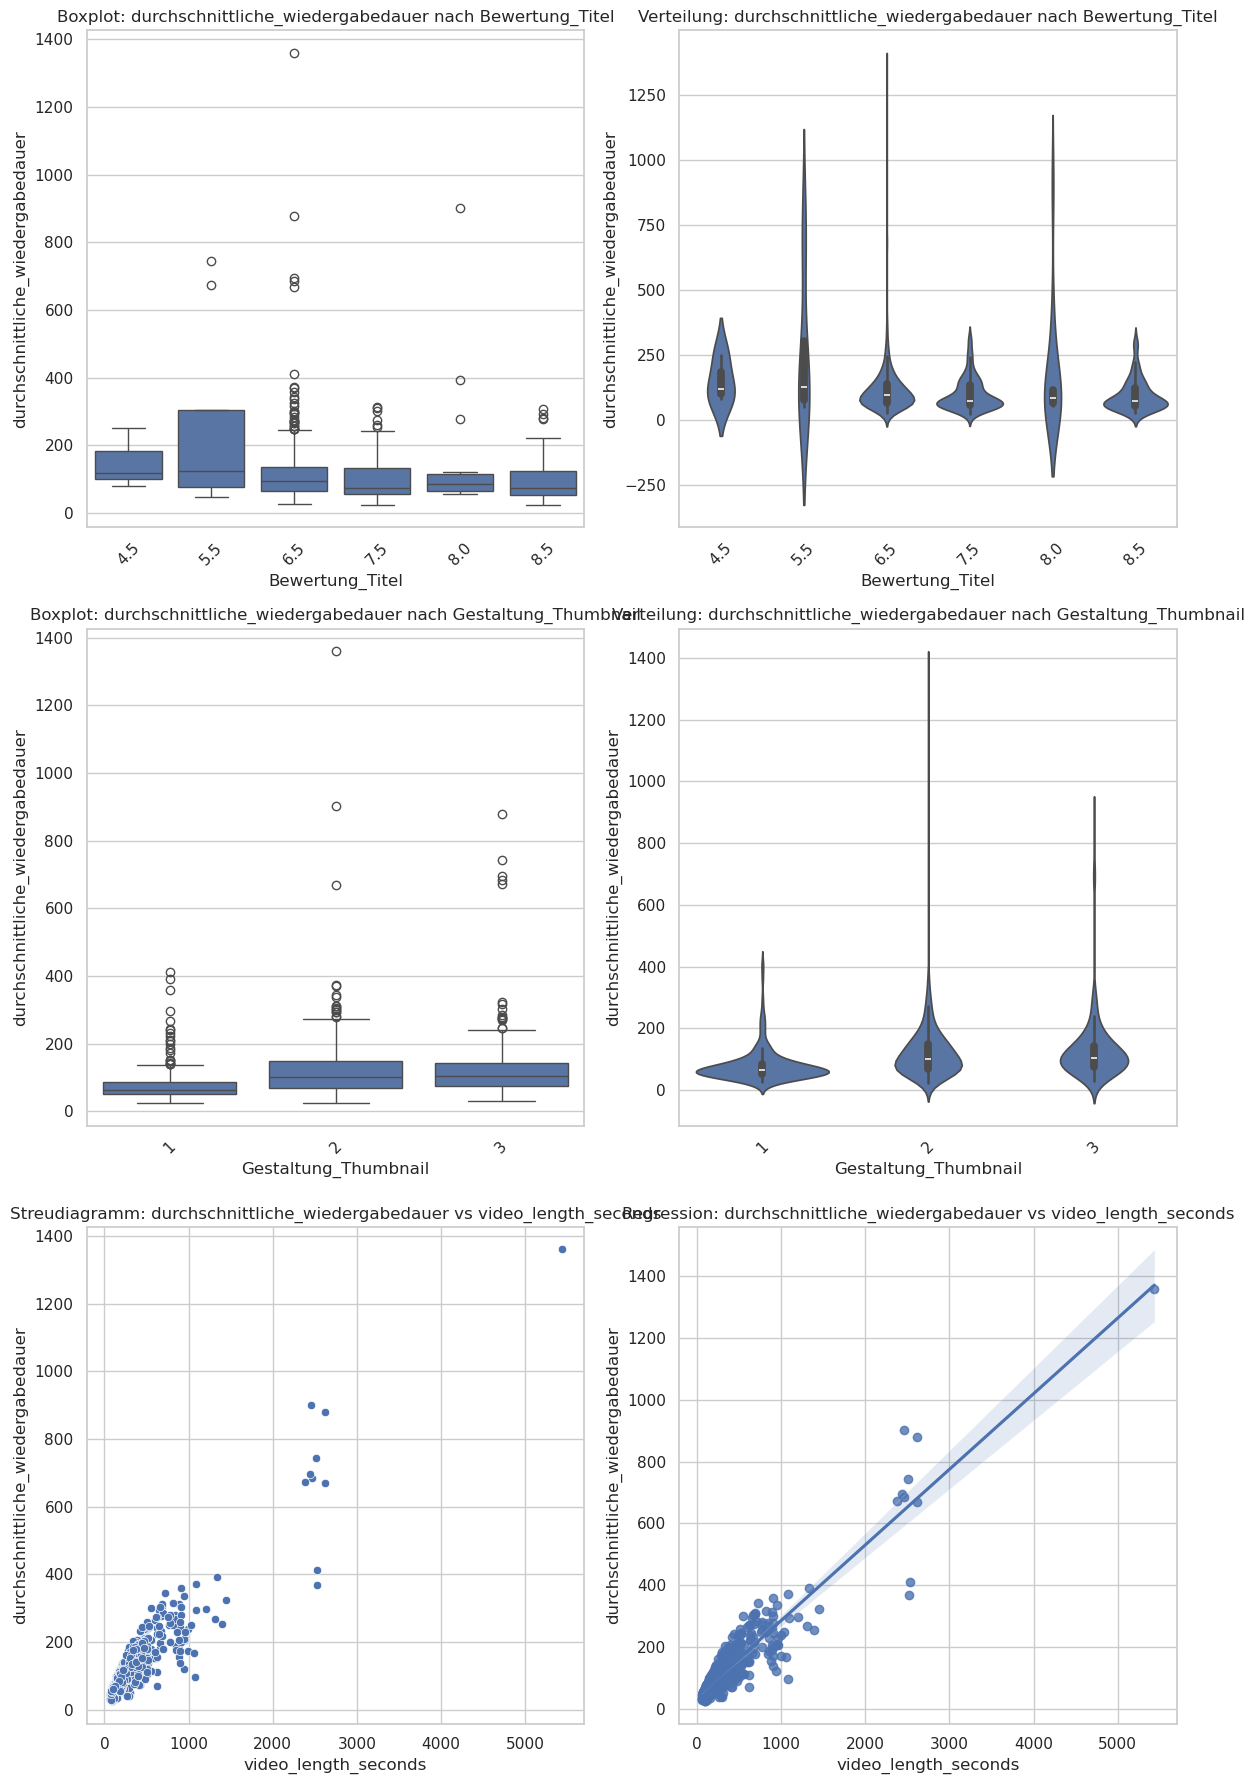

,durchschnittliche_wiedergabedauer,Bewertung_Titel,Gestaltung_Thumbnail,video_length_seconds
537,119.0,8.5,3,283
174,75.0,6.5,2,255
324,312.0,7.5,2,890
724,94.0,6.5,1,198
998,151.0,6.5,1,275
...,...,...,...,...
1386,55.0,7.5,3,83
478,134.0,6.5,1,331
1130,60.0,8.5,2,104
392,141.0,6.5,2,376


In [31]:
# Für Wiedergabedauer
flexible_analysis(X_train, y_train,
                  target_variable='durchschnittliche_wiedergabedauer',
                  predictor_variables=['Bewertung_Titel', 'Gestaltung_Thumbnail', 'video_length_seconds'])


In [ ]:
# Für Aufrufe
flexible_analysis(X_train, y_train,
                  target_variable='aufrufe',
                  predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel', 'video_length_seconds'])

### Ab hier werden die drei Analysen durchgeführt unter Aussschluss der Kategorie "Live"  
nur sinnvoll, wenn vorne auch in der Datenvorverarbeitung auch mit Live eingelesen wurde. Während der Analyse hat sich rausgestellt, dass die Live-Videos die Analyse erschweren, da es auch Videos sind, die überraschend vorkommen und kaum richtig vorbereitet werden können. Der Einfluss der beeinflußbaren Variablen ist also sehr gering.

In [ ]:
# Für Klickrate
flexible_analysis(
    X_train[X_train['theme_Live'] == 0], 
    y_train[X_train['theme_Live'] == 0],
    target_variable='Klickrate der Impressionen (%)',
    predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel']
)

In [ ]:

# Für Wiedergabedauer
flexible_analysis(
    X_train[X_train['theme_Live'] == 0], 
    y_train[X_train['theme_Live'] == 0],
    target_variable='durchschnittliche_wiedergabedauer',
    predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel']
)

In [ ]:

# Für Aufrufe
flexible_analysis(
    X_train[X_train['theme_Live'] == 0], 
    y_train[X_train['theme_Live'] == 0],
    target_variable='aufrufe',
    predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel']
)

### ab hier werden die Ausreißer rausgenommen  
Die Ausreisser werden je nach Zielvariable mit verschiedenen Methoden entfernt, IQR oder Z-Score-Methode, Live-Videos sind schon zuvor in den Daten ausgenommen, daher wurde der Code auskommentiert

In [32]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def remove_outliers(data, method='iqr', threshold=1.5):
    """
    Entfernt Ausreißer aus einer Serie basierend auf verschiedenen Methoden.
    
    Parameters:
    -----------
    data : pandas Series
        Zu bereinigende Daten
    method : str
        'iqr' für IQR-Methode
        'zscore' für Z-Score Methode
        'modified_zscore' für modifizierten Z-Score
    threshold : float
        Schwellenwert für die jeweilige Methode
    """
    if method == 'iqr':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        return (data >= lower_bound) & (data <= upper_bound)
    
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        return z_scores < threshold
    
    elif method == 'modified_zscore':
        median = data.median()
        mad = stats.median_abs_deviation(data)
        modified_z_scores = 0.6745 * (data - median) / mad
        return np.abs(modified_z_scores) < threshold
    
    return pd.Series([True] * len(data))

def flexible_analysis(X_data, y_data, target_variable, predictor_variables, 
                     outlier_method=None, outlier_threshold=1.5, output_dir='analysis_output'):
    """
    Führt flexible Analyse mit optionaler Ausreißerbehandlung durch.
    
    Parameters:
    -----------
    X_data, y_data : DataFrames mit Prädiktoren und Zielvariablen
    target_variable : str, Name der Zielvariable
    predictor_variables : list, Liste der Prädiktorvariablen
    outlier_method : str oder None, Methode der Ausreißerbehandlung
    outlier_threshold : float, Schwellenwert für Ausreißerbehandlung
    output_dir : str, Ausgabeverzeichnis
    """
    
    # Erstelle Ausgabeverzeichnis falls nicht vorhanden
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Filtere Live-Videos
    #non_live_mask = X_data['theme_Live'] == 0
    #X_filtered = X_data[non_live_mask]
    #y_filtered = y_data[non_live_mask]
    X_filtered = X_data
    y_filtered = y_data

    # Kombiniere Daten für die Analyse
    analysis_data = pd.DataFrame()
    analysis_data[target_variable] = y_filtered[target_variable]
    for pred in predictor_variables:
        analysis_data[pred] = X_filtered[pred]
    
    # Ausreißerbehandlung wenn gewünscht
    if outlier_method:
        print(f"Ausreißerbehandlung mit Methode: {outlier_method}, Schwellenwert: {outlier_threshold}")
        initial_size = len(analysis_data)
        mask = remove_outliers(analysis_data[target_variable], method=outlier_method, threshold=outlier_threshold)
        analysis_data = analysis_data[mask]
        print(f"Entfernte Datenpunkte: {initial_size - len(analysis_data)} ({((initial_size - len(analysis_data))/initial_size*100):.1f}%)")
    
    # Grundlegende statistische Analyse
    print(f"\nAnalyse für Zielvariable: {target_variable}")
    print("="*50)
    
    print("\nDeskriptive Statistik für Zielvariable:")
    print(analysis_data[target_variable].describe())
    
    # Analyse je Prädiktor
    for pred in predictor_variables:
        print(f"\nAnalyse für Prädiktor: {pred}")
        print("-"*30)
        
        print("\nDeskriptive Statistik:")
        print(analysis_data[pred].describe())
        
        # Für kategorische und metrische Variablen
        is_categorical = analysis_data[pred].nunique() < 10
        if is_categorical:
            print("\nGruppierte Statistiken:")
            grouped_stats = analysis_data.groupby(pred)[target_variable].agg(['mean', 'std', 'count'])
            print(grouped_stats)
            
            # ANOVA
            groups = [group for _, group in analysis_data.groupby(pred)[target_variable]]
            if len(groups) >= 2:
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"\nANOVA Test:")
                print(f"F-Statistik: {f_stat:.4f}")
                print(f"P-Wert: {p_val:.4f}")
                
                # Effektstärken
                categories = sorted(analysis_data[pred].unique())
                print("\nEffektstärken (Cohen's d):")
                for i in range(len(categories)):
                    for j in range(i + 1, len(categories)):
                        cat1 = categories[i]
                        cat2 = categories[j]
                        group1 = analysis_data[analysis_data[pred] == cat1][target_variable]
                        group2 = analysis_data[analysis_data[pred] == cat2][target_variable]
                        d = (group1.mean() - group2.mean()) / np.sqrt(
                            ((group1.std()**2 + group2.std()**2) / 2))
                        print(f"Kategorie {cat1} vs {cat2}: {d:.4f}")
        else:
            correlation = analysis_data[target_variable].corr(analysis_data[pred])
            print(f"\nKorrelation mit Zielvariable: {correlation:.4f}")
            
            # ANOVA (für metrische Prädiktoren)
            groups = [group for _, group in analysis_data.groupby(pred)[target_variable]]
            if len(groups) >= 2:
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"\nANOVA Test:")
                print(f"F-Statistik: {f_stat:.4f}")
                print(f"P-Wert: {p_val:.4f}")
    
    # Visualisierungen
    fig, axes = plt.subplots(len(predictor_variables), 2, figsize=(12, 6*len(predictor_variables)))
    if len(predictor_variables) == 1:
        axes = axes.reshape(1, 2)
    
    for i, pred in enumerate(predictor_variables):
        is_categorical = analysis_data[pred].nunique() < 10
        
        if is_categorical:
            # Boxplot
            sns.boxplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,0])
            axes[i,0].set_title(f'Boxplot: {target_variable} nach {pred}')
            axes[i,0].tick_params(axis='x', rotation=45)
            
            # Violinplot
            sns.violinplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,1])
            axes[i,1].set_title(f'Verteilung: {target_variable} nach {pred}')
            axes[i,1].tick_params(axis='x', rotation=45)
        else:
            # Streudiagramm
            sns.scatterplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,0])
            axes[i,0].set_title(f'Streudiagramm: {target_variable} vs {pred}')
            
            # Regression
            sns.regplot(x=pred, y=target_variable, data=analysis_data, ax=axes[i,1])
            axes[i,1].set_title(f'Regression: {target_variable} vs {pred}')
    
    plt.tight_layout()
    plt.show()
    
    return analysis_data


In [ ]:
# Beispielaufrufe:
# Für Klickrate mit IQR-Methode
flexible_analysis(X_train, y_train,
                  target_variable='Klickrate der Impressionen (%)',
                  predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel', 'video_length_seconds'],
                  outlier_method='iqr',
                  outlier_threshold=1.5)

In [ ]:
# Für Wiedergabedauer mit modifiziertem Z-Score
flexible_analysis(X_train, y_train,
                  target_variable='durchschnittliche_wiedergabedauer',
                  predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel', 'video_length_seconds'],
                  outlier_method='modified_zscore',
                  #outlier_method='iqr',                  
                  outlier_threshold=3.5)

In [ ]:
# Analyse für Views
# Für Aufrufe mit Z-Score
flexible_analysis(X_train, y_train,
                  target_variable='aufrufe',
                  predictor_variables=['Gestaltung_Thumbnail', 'Bewertung_Titel', 'video_length_seconds'],
                  outlier_method='zscore',
                  outlier_threshold=3)

### Regressionsanalyse Wiedergabedauer
Die Videolänge hat den stärksten Einfluss auf die Wiedergabedauer, was auch logisch scheint. Die Thumbnail-Gestaltung zeigt ebenfalls einen deutlichen Effekt Die Titelbewertung hat einen signifikanten, aber weniger ausgeprägten Einfluss
Alle drei Prädiktoren sind statistisch signifikant.

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def load_pickle_data():
    """Lädt die vorverarbeiteten Daten aus dem Pickle-Objekt"""
    with open('../data/processed/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

def prepare_features(X):
    """
    Bereitet die Features für die Modellierung vor
    - Behält nur numerische Spalten
    - Entfernt Spalten mit fehlenden Werten
    """
    # Nur numerische Spalten behalten
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X_numeric = X[numeric_cols]
    
    # Spalten mit fehlenden Werten entfernen
    X_clean = X_numeric.dropna(axis=1)
    
    print("Verwendete Features:")
    print(X_clean.columns.tolist())
    
    return X_clean

def remove_outliers(X, y, method='iqr', threshold=1.5):
    """Entfernt Ausreißer basierend auf der gewählten Methode - für die Zielvariable"""
    if method == 'iqr':
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((y < (Q1 - threshold * IQR)) | (y > (Q3 + threshold * IQR)))
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(y))
        mask = z_scores < threshold
    
    X_clean = X[mask]
    y_clean = y[mask]
    
    print(f"Ausreißerbehandlung mit Methode: {method}, Schwellenwert: {threshold}")
    print(f"Entfernte Datenpunkte: {len(y) - len(y_clean)} ({(1 - len(y_clean)/len(y))*100:.1f}%)")
    
    return X_clean, y_clean

def train_models(X, y):
    """Trainiert verschiedene Regressionsmodelle und vergleicht ihre Performance"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0)
    }
    
    results = {}
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Cross-Validation Scores
        cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-cv_scores)
        
        # Modell auf gesamten Datensatz trainieren
        model.fit(X, y)
        y_pred = model.predict(X)
        
        results[name] = {
            'model': model,
            'cv_rmse_mean': rmse_scores.mean(),
            'cv_rmse_std': rmse_scores.std(),
            'r2_score': r2_score(y, y_pred),
            'mae': mean_absolute_error(y, y_pred),
            'predictions': y_pred
        }
        
        # Feature Importance für Linear und Ridge Regression
        if name in ['Linear Regression', 'Ridge Regression']:
            results[name]['feature_importance'] = pd.DataFrame({
                'feature': X.columns,
                'importance': model.coef_
            }).sort_values('importance', ascending=False)
    
    return results

def analyze_residuals(y_true, y_pred, title="Residuenanalyse"):
    """Führt eine detaillierte Residuenanalyse durch"""
    residuals = y_true - y_pred
    
    # Plot erstellen
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title)
    
    # Residuen vs. vorhergesagte Werte
    axes[0,0].scatter(y_pred, residuals, alpha=0.5)
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Vorhergesagte Werte')
    axes[0,0].set_ylabel('Residuen')
    axes[0,0].set_title('Residuen vs. Vorhergesage')
    
    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot')
    
    # Histogramm der Residuen
    axes[1,0].hist(residuals, bins=30)
    axes[1,0].set_xlabel('Residuen')
    axes[1,0].set_ylabel('Häufigkeit')
    axes[1,0].set_title('Verteilung der Residuen')
    
    # Tatsächliche vs. vorhergesagte Werte
    axes[1,1].scatter(y_true, y_pred, alpha=0.5)
    axes[1,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[1,1].set_xlabel('Tatsächliche Werte')
    axes[1,1].set_ylabel('Vorhergesagte Werte')
    axes[1,1].set_title('Vorhersage vs. Realität')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiken der Residuen
    print("\nStatistiken der Residuen:")
    print(f"Mittelwert: {residuals.mean():.4f}")
    print(f"Standardabweichung: {residuals.std():.4f}")
    print(f"Schiefe: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")
    
    # Shapiro-Wilk Test auf Normalverteilung
    _, p_value = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test p-Wert: {p_value:.4f}")
    
    # Breusch-Pagan Test auf Homoskedastizität
    _, p_value = stats.levene(residuals, y_pred)
    print(f"Breusch-Pagan Test p-Wert: {p_value:.4f}")

def main():
    # Daten laden
    data = load_pickle_data()
    
    # Features vorbereiten
    X_train = prepare_features(data['X_train'])
    X_val = prepare_features(data['X_val'])
    
    # Zielvariablen extrahieren
    y_train = data['y_train']['durchschnittliche_wiedergabedauer']
    y_val = data['y_val']['durchschnittliche_wiedergabedauer']
    
    # Ausreißer entfernen
    X_train_clean, y_train_clean = remove_outliers(X_train, y_train, method='iqr', threshold=1.5)
    
    # Modelle trainieren
    results = train_models(X_train_clean, y_train_clean)
    
    # Ergebnisse ausgeben
    print("\nModellvergleich:")
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"Cross-validated RMSE: {result['cv_rmse_mean']:.2f} (+/- {result['cv_rmse_std']:.2f})")
        print(f"R² Score: {result['r2_score']:.4f}")
        print(f"MAE: {result['mae']:.4f}")
        
        # Feature Importance ausgeben falls vorhanden
        if 'feature_importance' in result:
            print("\nTop 5 wichtigste Features:")
            print(result['feature_importance'].head())
    
    # Bestes Modell auswählen
    best_model = max(results.items(), key=lambda x: x[1]['r2_score'])
    print(f"\nBestes Modell: {best_model[0]}")
    
    # Validierung auf Validierungsdatensatz
    final_predictions = best_model[1]['model'].predict(X_val)
    val_r2 = r2_score(y_val, final_predictions)
    val_rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
    print(f"\nValidierungsergebnisse:")
    print(f"R² Score: {val_r2:.4f}")
    print(f"RMSE: {val_rmse:.2f}")
    
    # Residuenanalyse für bestes Modell
    analyze_residuals(y_train_clean, best_model[1]['predictions'], 
                     title=f"Residuenanalyse - {best_model[0]}")
    
    return results, best_model[1]['model']

if __name__ == "__main__":
    results, best_model = main()

### Regressionsanalyse mit Modell mit spez. Vorgaben für Features (TOP-ERGEBNIS) Modellierung durchschn. Wiedergabedauer
mit AUsgabe der Modellparameter

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def load_and_filter_data():
    """Lädt die Pickle-Daten und filtert die relevanten Features"""
    with open('../data/processed/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    # Zeitliche Features aus publish_date extrahieren
    for dataset in ['X_train', 'X_val', 'X_test']:
        if 'publish_date' in data[dataset].columns:
            # Konvertiere zu datetime mit deutschem Format
            data[dataset]['publish_date'] = pd.to_datetime(data[dataset]['publish_date'], 
                                                         format='%d.%m.%Y %H:%M')
            # Extrahiere Stunde und Wochentag
            data[dataset]['publish_hour'] = data[dataset]['publish_date'].dt.hour
            data[dataset]['publish_weekday'] = data[dataset]['publish_date'].dt.dayofweek
    
    # Liste der zu behaltenden Features
    keep_features = [
        'video_length_seconds',
        'Gestaltung_Thumbnail',
        'Bewertung_Titel',
        'publish_hour',
        'publish_weekday'
    ]
    
    # Thema-Dummy-Variablen finden und hinzufügen
    #theme_features = [col for col in data['X_train'].columns if col.startswith('theme_')]
    # Thema-Dummy-Variablen finden und hinzufügen, aber ohne "Live"-Dummy, da ja auch keine Live-Videos mehr dabei sind
    theme_features = [col for col in data['X_train'].columns if col.startswith('theme_') and not col.endswith('Live')]
    keep_features.extend(theme_features)
    
    # Features filtern
    X_train = data['X_train'][keep_features]
    X_val = data['X_val'][keep_features]
    X_test = data['X_test'][keep_features]
    
    # Zielvariable
    y_train = data['y_train']['durchschnittliche_wiedergabedauer']
    y_val = data['y_val']['durchschnittliche_wiedergabedauer']
    y_test = data['y_test']['durchschnittliche_wiedergabedauer']
    
    print("Verwendete Features:")
    print(X_train.columns.tolist())
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def remove_outliers(X, y, method='iqr', threshold=1.5):
    """Entfernt Ausreißer basierend auf der gewählten Methode"""
    if method == 'iqr':
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((y < (Q1 - threshold * IQR)) | (y > (Q3 + threshold * IQR)))
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(y))
        mask = z_scores < threshold
    
    X_clean = X[mask]
    y_clean = y[mask]
    
    print(f"Ausreißerbehandlung mit Methode: {method}, Schwellenwert: {threshold}")
    print(f"Entfernte Datenpunkte: {len(y) - len(y_clean)} ({(1 - len(y_clean)/len(y))*100:.1f}%)")
    
    return X_clean, y_clean

def train_models(X, y):
    """Trainiert verschiedene Regressionsmodelle und vergleicht ihre Performance"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0)
    }
    
    results = {}
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Cross-Validation Scores
        cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-cv_scores)
        
        # Modell auf gesamten Datensatz trainieren
        model.fit(X, y)
        y_pred = model.predict(X)
        
        results[name] = {
            'model': model,
            'cv_rmse_mean': rmse_scores.mean(),
            'cv_rmse_std': rmse_scores.std(),
            'r2_score': r2_score(y, y_pred),
            'mae': mean_absolute_error(y, y_pred),
            'predictions': y_pred
        }
        
        # Feature Importance für Linear und Ridge Regression
        if name in ['Linear Regression', 'Ridge Regression']:
            results[name]['feature_importance'] = pd.DataFrame({
                'feature': X.columns,
                'importance': model.coef_
            }).sort_values('importance', key=lambda x: abs(x), ascending=False)  # Sortierung nach absolutem Wert
    
    return results

def analyze_residuals(y_true, y_pred, title="Residuenanalyse"):
    """Führt eine detaillierte Residuenanalyse durch"""
    residuals = y_true - y_pred
    
    # Plot erstellen
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title)
    
    # Residuen vs. vorhergesagte Werte
    axes[0,0].scatter(y_pred, residuals, alpha=0.5)
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Vorhergesagte Werte')
    axes[0,0].set_ylabel('Residuen')
    axes[0,0].set_title('Residuen vs. Vorhergesage')
    
    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot')
    
    # Histogramm der Residuen
    axes[1,0].hist(residuals, bins=30)
    axes[1,0].set_xlabel('Residuen')
    axes[1,0].set_ylabel('Häufigkeit')
    axes[1,0].set_title('Verteilung der Residuen')
    
    # Tatsächliche vs. vorhergesagte Werte
    axes[1,1].scatter(y_true, y_pred, alpha=0.5)
    axes[1,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[1,1].set_xlabel('Tatsächliche Werte')
    axes[1,1].set_ylabel('Vorhergesagte Werte')
    axes[1,1].set_title('Vorhersage vs. Realität')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiken der Residuen
    print("\nStatistiken der Residuen:")
    print(f"Mittelwert: {residuals.mean():.4f}")
    print(f"Standardabweichung: {residuals.std():.4f}")
    print(f"Schiefe: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")
    
    # Shapiro-Wilk Test auf Normalverteilung
    _, p_value = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test p-Wert: {p_value:.4f}")
    
    # Breusch-Pagan Test auf Homoskedastizität
    _, p_value = stats.levene(residuals, y_pred)
    print(f"Breusch-Pagan Test p-Wert: {p_value:.4f}")

def main():
    # 1) Daten laden und filtern
    X_train, X_val, X_test, y_train, y_val, y_test = load_and_filter_data()
    
    # 2) Ausreißer entfernen
    X_train_clean, y_train_clean = remove_outliers(X_train, y_train, method='iqr', threshold=1.5)
    
    # 3) Modelle trainieren
    results = train_models(X_train_clean, y_train_clean)
    
    # 4) Ergebnisse ausgeben
    print("\nModellvergleich:")
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"Cross-validated RMSE: {result['cv_rmse_mean']:.2f} (+/- {result['cv_rmse_std']:.2f})")
        print(f"R² Score: {result['r2_score']:.4f}")
        print(f"MAE: {result['mae']:.4f}")
        
        if 'feature_importance' in result:
            print("\nFeature Importance:")
            print(result['feature_importance'])
    
    # 5) Bestes Modell auswählen
    best_model_tuple = max(results.items(), key=lambda x: x[1]['r2_score'])  # CHANGED: rename to _tuple
    best_model_name = best_model_tuple[0]   # z.B. "Linear Regression"
    best_model_info = best_model_tuple[1]   # dictionary mit {'model':..., 'predictions':..., ...}

    sklearn_model = best_model_info['model']  # ADDED: Hol dir das Modellobjekt
    print(f"\nBestes Modell: {best_model_name}")
    
    # 6) Validierung
    final_predictions = sklearn_model.predict(X_val)
    val_r2 = r2_score(y_val, final_predictions)
    val_rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
    print(f"\nValidierungsergebnisse:")
    print(f"R² Score: {val_r2:.4f}")
    print(f"RMSE: {val_rmse:.2f}")
    
    # 7) Residuenanalyse
    analyze_residuals(y_train_clean, best_model_info['predictions'], 
                     title=f"Residuenanalyse - {best_model_name}")
    
    # 8) Intercept & Coefficients für lineare Modelle ausgeben - ADDED
    if hasattr(sklearn_model, 'coef_') and hasattr(sklearn_model, 'intercept_'):
        intercept = sklearn_model.intercept_
        coefficients = sklearn_model.coef_
        features = X_train_clean.columns
        
        print("\n--- Lineare Modellformel / Koeffizienten ---")
        print(f"Intercept: {intercept:.4f}")
        
        for feat, coef_val in zip(features, coefficients):
            print(f"{feat}: {coef_val:.4f}")
    
    # 9) Rückgabe (unverändert, nur best_model_tuple -> best_model_info['model'])
    return results, sklearn_model  # CHANGED: Return the sklearn_model directly

    

if __name__ == "__main__":
    results, best_model = main()

### **Forward Feature Selection**, (für ausgewählte Prädiktoren)



nur für ausgewählte Prädiktoren, die man auch beeinflussen kann.

Dauer des Videos (z. B. video_length_seconds)
Thema (Dummy-Variablen wie theme_Bilder, theme_Krieg, theme_Politik, theme_Sonstiges, theme_Wirtschaft – falls du noch andere Themen hast, kannst du sie hinzufügen)
Titel-Bewertung (z. B. Bewertung_Titel)
Thumbnail-Gestaltung (z. B. Gestaltung_Thumbnail)
Wochentag der Veröffentlichung (publish_weekday)
Stunde der Veröffentlichung (publish_hour)

Alle anderen Variablen, auf die du keinen direkten Einfluss hast (z. B. bereits vorhandene Klick-Statistiken oder sonstige automatisierte Messgrößen), werden hier nicht berücksichtigt.

**Erläuterungen**

candidate_features enthält genau die Spalten, auf die du direkt Einfluss nehmen kannst (Videolänge, Thema, Titelbewertung, Thumbnail, Publikationszeit, etc.).
Wenn in deinem DataFrame noch weitere Spalten stehen, filterst du sie raus, damit der Forward-Selection-Prozess nur auf diesen beeinflussbaren Variablen arbeitet.
theme_Live wird ignoriert/gelöscht, falls es existiert, weil du es explizit ausschließen wolltest.
Ablauf:
Start: Keine Features im Modell.
Schrittweise:
Probiere jedes noch nicht ausgewählte Feature einzeln aus.
Berechne z. B. den Cross-Validation-R² (Standard: 5-Fold).
Nimm das Feature, das den Score am meisten steigert.
Wiederhole, bis alle Features eingebaut wurden oder bis du entscheidest, dass dir die Performance reicht.
Am Ende findest du eine Reihenfolge der „wichtigsten“ Features und kannst je nach Komplexität ein Modell mit all diesen (oder nur den Top-k) Merkmalen nutzen.
**Was du damit gewinnst**

Du siehst zum Beispiel, ob Gestaltung_Thumbnail zuerst aufgenommen wird (starker Effekt) oder ob vielleicht theme_Krieg einen größeren Einfluss hat.
Du erfährst, ob publish_hour oder publish_weekday überhaupt eine nennenswerte Verbesserung bringen, oder erst ganz am Ende (falls überhaupt).
Das Endergebnis kann dir helfen, gezielt an den Stellschrauben zu drehen, die du tatsächlich beeinflussen kannst, anstatt das Modell mit irrelevanten oder unveränderbaren Features zu überfrachten.



In [ ]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from itertools import combinations

#TARGET_VAR = "durchschnittliche_wiedergabedauer"  # Zielvariable ist durchschn. Wiedergabedauer
#TARGET_VAR = "aufrufe"  # Aufrufe (views)
TARGET_VAR = "Klickrate der Impressionen (%)"  # Klickrate der Impressionen

def forward_feature_selection(X, y, 
                              scoring='r2', 
                              n_splits=5, 
                              random_state=42):
    """
    Führt eine Vorwärtsselektion (Forward Feature Selection) durch,
    basierend auf dem ausgewählten Scoring (Standard: R²).
    
    :param X: pd.DataFrame mit den rein beeinflussbaren Features
    :param y: pd.Series oder np.array mit der Zielvariable
    :param scoring: 'r2' oder 'neg_mean_squared_error'
    :param n_splits: Anzahl K-Folds in der Cross-Validation
    :param random_state: Zufallssamen für Reproduzierbarkeit
    :return: 
       selected_features (List): Features in der Reihenfolge ihrer Aufnahme
       best_models (Dict): Zwischenergebnisse 
           Key = Tuple(Features), Value = (Train_R2, Train_RMSE, Train_MAE, Modellobjekt)
    """
    
    all_features = list(X.columns)  # Alle möglichen Features, die DU beeinflussen kannst
    
    selected_features = []          # Start: Keine Features
    remaining_features = set(all_features)
    best_models = {}
    
    while remaining_features:
        best_score = -np.inf
        best_feature = None
        
        # Teste jedes Feature, das noch nicht ausgewählt ist
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_sub = X[current_features]
            
            model = LinearRegression()
            
            # Cross-Validation (für R² oder neg_mean_squared_error)
            kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            
            if scoring == 'r2':
                cv_scores = cross_val_score(model, X_sub, y, cv=kfold, scoring='r2')
                mean_score = cv_scores.mean()
            elif scoring == 'neg_mean_squared_error':
                cv_scores = cross_val_score(model, X_sub, y, cv=kfold, scoring='neg_mean_squared_error')
                # Hier sind die Werte negativ, da MSE "minimiert" wird. 
                # Man könnte -mean_score nehmen, um "maximieren" zu simulieren. 
                # Für Forward-Selection reicht es oft, den Mittelwert direkt zu vergleichen.
                mean_score = cv_scores.mean()
            else:
                raise ValueError("Bitte scoring='r2' oder 'neg_mean_squared_error' verwenden.")
            
            # Wähle jenes Feature, das den besten (höchsten) Score liefert
            if mean_score > best_score:
                best_score = mean_score
                best_feature = feature
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            
            # Trainiere ein finales Modell auf dem gesamten Datensatz (Train) mit den ausgewählten Features
            X_sub = X[selected_features]
            final_model = LinearRegression()
            final_model.fit(X_sub, y)
            
            # Metriken auf dem gesamten Trainingsset (optional, zur Info)
            y_pred = final_model.predict(X_sub)
            train_r2 = r2_score(y, y_pred)
            train_rmse = np.sqrt(mean_squared_error(y, y_pred))
            train_mae = np.mean(np.abs(y - y_pred))
            
            best_models[tuple(selected_features)] = (train_r2, train_rmse, train_mae, final_model)
            
            print(f"Feature hinzugefügt: {best_feature}. "
                  f"Aktuelle Liste: {selected_features}. "
                  f"(Train R²={train_r2:.4f}, RMSE={train_rmse:.2f}, MAE={train_mae:.2f})")
        else:
            # Wenn kein Feature den Score steigert, brechen wir
            break
    
    return selected_features, best_models

def main():
    # 1) Daten laden
    with open('../data/processed/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Zeitliche Features aus publish_date extrahieren
    for dataset in ['X_train', 'X_val']:
        if 'publish_date' in data[dataset].columns:
            data[dataset]['publish_date'] = pd.to_datetime(
                data[dataset]['publish_date'], 
                format='%d.%m.%Y %H:%M'
            )
            data[dataset]['publish_hour'] = data[dataset]['publish_date'].dt.hour
            data[dataset]['publish_weekday'] = data[dataset]['publish_date'].dt.dayofweek
    
    # 2) Trainings- und Validierungsdaten laden
    X_train = data['X_train'].copy()
    y_train = data['y_train'][TARGET_VAR].copy()
    
    X_val = data['X_val'].copy()
    y_val = data['y_val'][TARGET_VAR].copy()
    
    # 3) Nur beeinflussbare Features (ohne theme_Live) behalten
    candidate_features = [
        'video_length_seconds',
        'Gestaltung_Thumbnail',
        'Bewertung_Titel',
        'publish_hour',
        'publish_weekday',
        'theme_Bilder',
        'theme_Krieg',
        'theme_Politik',
        'theme_Sonstiges',
        'theme_Wirtschaft'
    ]
    
    # Falls "theme_Live" existiert, ausschließen
    if 'theme_Live' in X_train.columns:
        X_train.drop(columns=['theme_Live'], inplace=True, errors='ignore')
    if 'theme_Live' in X_val.columns:
        X_val.drop(columns=['theme_Live'], inplace=True, errors='ignore')
    
    # Filter auf die Candidate-Features
    X_train = X_train[candidate_features]
    X_val = X_val[candidate_features]
    
    # 4) Forward Feature Selection (auf Trainingsdaten)
    selected_feats, models_dict = forward_feature_selection(
        X_train, 
        y_train, 
        scoring='r2',           # oder 'neg_mean_squared_error'
        n_splits=5, 
        random_state=42
    )
    
    print("\n--- Vorwärtsselektion abgeschlossen ---")
    print("Ausgewählte Features (in Reihenfolge der Aufnahme):")
    for feat in selected_feats:
        print("  ", feat)
    
    # 5) Bestes Modell anhand des höchsten Train-R²
    best_key = max(models_dict.keys(), key=lambda k: models_dict[k][0])  # Sortiere nach R²
    best_r2, best_rmse, best_mae, best_model = models_dict[best_key]
    
    # 6) Test des besten Modells auf dem Validierungsdatensatz
    X_val_sub = X_val[list(best_key)]
    y_val_pred = best_model.predict(X_val_sub)
    
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    print("\n--- Validierungsergebnisse mit dem besten Modell ---")
    print(f"Train R² = {best_r2:.4f}, Val R² = {val_r2:.4f}")
    print(f"Train RMSE = {best_rmse:.2f}, Val RMSE = {val_rmse:.2f}")
    print(f"Train MAE = {best_mae:.2f}, Val MAE = {val_mae:.2f}")
    
    # 7) Ausgabe der Koeffizienten (optional)
    coef_df = pd.DataFrame({
        'Feature': list(best_key),
        'Coefficient': best_model.coef_
    })
    print("\nKoeffizienten des finalen Modells:")
    print("Intercept:", best_model.intercept_)
    print(coef_df)
    
    # -----------------------------------
    # 8) MODEL & INFO SPEICHERN
    # -----------------------------------
    # Ordner "models" anlegen, falls nicht vorhanden
    os.makedirs("../models", exist_ok=True)
    
    # Model-Dateiname (z.B. best_model_durchschnittliche_wiedergabedauer.pkl)
    model_filename = f"../models/best_model_{TARGET_VAR}.pkl"
    joblib.dump(best_model, model_filename)
    print(f"\nModell gespeichert in: {model_filename}")
    
    # Wichtigste Kennzahlen & Parameter als JSON speichern
    model_info = {
        "target_variable": TARGET_VAR,
        "selected_features": list(best_key),
        "train_r2": round(best_r2, 4),
        "train_rmse": round(best_rmse, 2),
        "train_mae": round(best_mae, 2),
        "val_r2": round(val_r2, 4),
        "val_rmse": round(val_rmse, 2),
        "val_mae": round(val_mae, 2),
        "coefficients": {
            "Intercept": round(best_model.intercept_, 4)
        }
    }
    # Coefficients-Detail
    for feat, coef_val in zip(best_key, best_model.coef_):
        model_info["coefficients"][feat] = round(float(coef_val), 4)
    
    # JSON-Dateiname (z.B. best_model_durchschnittliche_wiedergabedauer_info.json)
    json_filename = f"../models/best_model_{TARGET_VAR}_info.json"
    with open(json_filename, "w", encoding="utf-8") as f:
        json.dump(model_info, f, indent=2, ensure_ascii=False)
    
    print(f"\nModell-Informationen als JSON gespeichert in: {json_filename}")


if __name__ == "__main__":
    main()


Ladevorgang Model und Kennzahlen testen

In [ ]:
import joblib
import json

loaded_model = joblib.load('../models/best_model_durchschnittliche_wiedergabedauer.pkl')

#Jetzt kann mit loaded_model.predict(X) das Model aufgerufen werden

json_filename = "../models/best_model_durchschnittliche_wiedergabedauer_info.json"

# JSON laden
with open(json_filename, "r", encoding="utf-8") as f:
    model_info = json.load(f)

# Kennzahlen ausgeben
print("Zielvariable:", model_info["target_variable"])
print("Ausgewählte Features:", model_info["selected_features"])
print("Train R²:", model_info["train_r2"])
print("Train RMSE:", model_info["train_rmse"])
print("Train MAE:", model_info["train_mae"])
print("Val R²:", model_info["val_r2"])
print("Val RMSE:", model_info["val_rmse"])
print("Val MAE:", model_info["val_mae"])

# Falls du die Koeffizienten (Intercept + weitere) ausgeben möchtest:
print("\nKoeffizienten:")
for feat, coef_val in model_info["coefficients"].items():
    print(f"{feat}: {coef_val}")

#### Verteilungstest zwischen Validierung und Trainings-Set


In [ ]:
def check_p_values(data_train, data_val, title=""):
    """Berechnet p-Werte für Verteilungsvergleiche"""
    if pd.api.types.is_numeric_dtype(data_train):
        try:
            # Kolmogorov-Smirnov Test
            _, ks_pval = stats.ks_2samp(data_train, data_val)
            # Mann-Whitney U Test
            _, mw_pval = stats.mannwhitneyu(data_train, data_val, alternative='two-sided')
            
            print(f"{title}:")
            print(f"KS-Test p-Wert: {ks_pval:.4f}")
            print(f"MW-Test p-Wert: {mw_pval:.4f}")
            print("-" * 50)
        except Exception as e:
            print(f"{title}: Tests nicht möglich - {str(e)}")

def compare_all_p_values(X_train, X_val, y_train, y_val):
    """Vergleicht p-Werte für alle Features und Zielvariable"""
    print("P-Werte für Features:")
    print("=" * 50)
    for column in X_train.columns:
        check_p_values(X_train[column], X_val[column], title=column)
    
    print("\nP-Werte für Zielvariable:")
    print("=" * 50)
    check_p_values(
        y_train['durchschnittliche_wiedergabedauer'],
        y_val['durchschnittliche_wiedergabedauer'],
        "Wiedergabedauer"
    )

# Aufruf:
compare_all_p_values(X_train, X_val, y_train, y_val)

In [ ]:
def check_theme_distribution(X_train, X_val, X_test):
    # Für jedes Theme-Feature (theme_*)
    theme_cols = [col for col in X_train.columns if col.startswith('theme_')]
    
    for theme in theme_cols:
        print(f"\nVerteilung für {theme}:")
        print(f"Training:   {X_train[theme].mean():.3f}")
        print(f"Validierung: {X_val[theme].mean():.3f}")
        print(f"Test:       {X_test[theme].mean():.3f}")

# Aufruf
check_theme_distribution(X_train, X_val, X_test)

### Letzter Vergleich der Modelle am Test-Set


In [ ]:
import os
import json
import pickle
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def main():
    # 1) Ziele definieren: Du hast 3 Zielvariablen
    target_vars = [
        "Klickrate der Impressionen (%)",
        "durchschnittliche_wiedergabedauer",
        "aufrufe"
    ]
    
    # 2) Daten laden (inkl. X_test, y_test)
    with open('../data/processed/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    X_test = data['X_test'].copy()
    y_test_data = data['y_test']  # DataFrame oder Series mit allen Zielspalten
    
    # Falls 'publish_date' oder 'theme_Live' etc. noch aufbereitet werden muss, hier tun:
    if 'publish_date' in X_test.columns:
        X_test['publish_date'] = pd.to_datetime(X_test['publish_date'], format='%d.%m.%Y %H:%M')
        X_test['publish_hour'] = X_test['publish_date'].dt.hour
        X_test['publish_weekday'] = X_test['publish_date'].dt.dayofweek
    
    if 'theme_Live' in X_test.columns:
        X_test.drop(columns=['theme_Live'], inplace=True, errors='ignore')
    
    # 3) Ergebnisse sammeln
    results_list = []  # Speichert alle Ergebnisse in einer Liste von Dicts
    
    for target in target_vars:
        # a) JSON-Datei mit den Kennzahlen laden
        json_path = f"../models/best_model_{target}_info.json"
        if not os.path.exists(json_path):
            print(f"Warnung: {json_path} nicht gefunden. Überspringe {target}.")
            continue
        
        with open(json_path, "r", encoding="utf-8") as jf:
            model_info = json.load(jf)
        
        # b) Modell laden (pkl-Datei)
        model_path = f"../models/best_model_{target}.pkl"
        if not os.path.exists(model_path):
            print(f"Warnung: {model_path} nicht gefunden. Überspringe {target}.")
            continue
        
        best_model = joblib.load(model_path)
        
        # c) Benötigte Features laut JSON
        selected_features = model_info.get("selected_features", [])
        
        # d) Test-Zielwerte extrahieren
        if target not in y_test_data.columns:
            print(f"Zielvariable '{target}' nicht in y_test_data. Überspringe.")
            continue
        y_test = y_test_data[target].copy()
        y_test_str = data['y_test'][target].astype(str)
        y_test_str = y_test_str.str.replace(",", ".")
        y_test = y_test_str.astype(float)

        # e) X_test nach den im Modell verwendeten Features filtern
        X_test_sub = X_test[selected_features].copy()
        
        # f) Vorhersage auf dem Testset
        y_test_pred = best_model.predict(X_test_sub)
        
        # g) Kennzahlen berechnen
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # h) Vergleich mit Train/Val aus model_info
        train_r2 = model_info.get("train_r2", None)
        val_r2   = model_info.get("val_r2", None)
        train_rmse = model_info.get("train_rmse", None)
        val_rmse   = model_info.get("val_rmse", None)
        train_mae  = model_info.get("train_mae", None)
        val_mae    = model_info.get("val_mae", None)
        
        # i) Speichere Zusammenfassung in Dict
        results_list.append({
            "Zielvariable": target,
            "Train R²": train_r2,
            "Val R²": val_r2,
            "Test R²": round(test_r2, 4),
            "Train RMSE": train_rmse,
            "Val RMSE": val_rmse,
            "Test RMSE": round(test_rmse, 2),
            "Train MAE": train_mae,
            "Val MAE": val_mae,
            "Test MAE": round(test_mae, 2),
            "Features": selected_features
        })
    
    # 4) Ausgabe in schöner Tabellenform
    if results_list:
        results_df = pd.DataFrame(results_list)
        print("\n=== Zusammenfassung aller Modelle (Train/Val/Test) ===")
        print(results_df.to_string(index=False))
    else:
        print("Keine Ergebnisse. Wurden die JSON- und pkl-Dateien gefunden?")
        

if __name__ == "__main__":
    main()
